In [1]:
import numpy as np

results = np.load("/home/vhsingh/openfoam10-run/Geo-UPSplus/dataset_gen/FlowBench_Openfoam/Regular/FPO_Pipe/results_batch_1.npy")

print(results.shape)

(1, 12, 16384, 4)


Loading simulation data from /home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_External/Regular/results_batch_1.npy
Data shape: (1, 20, 16384, 5)
Parsing cell centers from C file: /home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_External/Regular/Design_Point_0/0/C
Cell centers shape: (16384, 2)


Reshaping Trajectories: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
/tmp/ipykernel_76290/2509794920.py:209: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('gist_ncar').copy()


Combined reshaped data shape: (1, 20, 128, 128, 9)
Combined reshaped data saved to output/combined_reshaped.npy
Saved grid values to output/sdf.txt
Saved grid values to output/mask.txt
Plotting sample trajectory (index 58)...


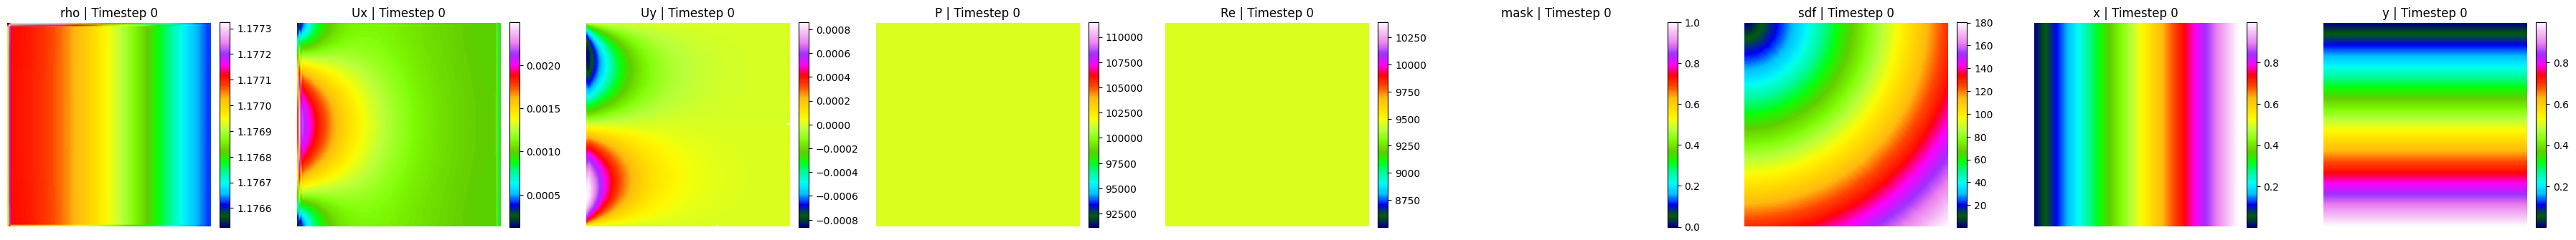

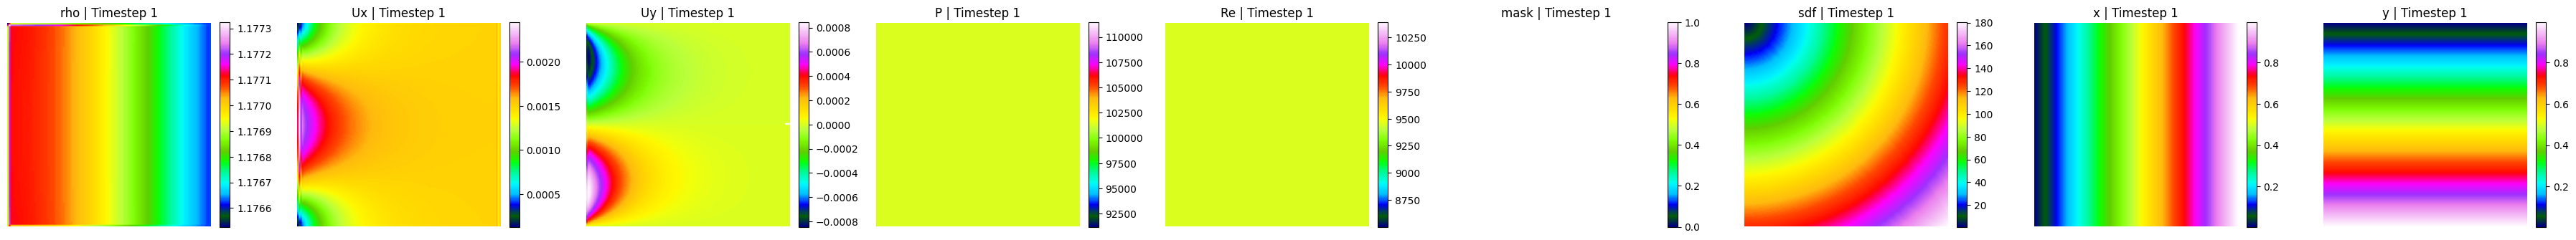

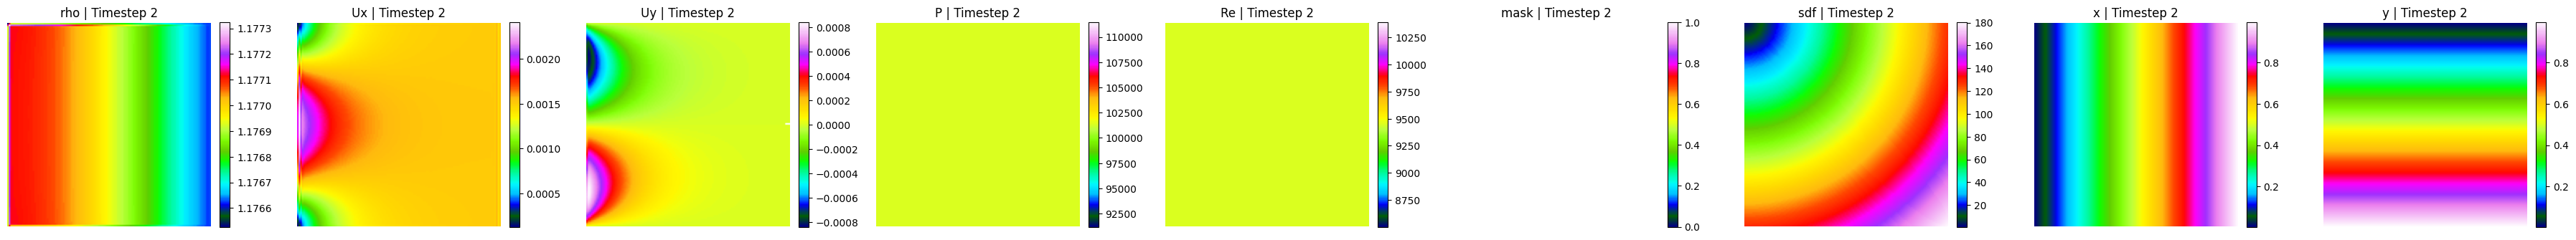

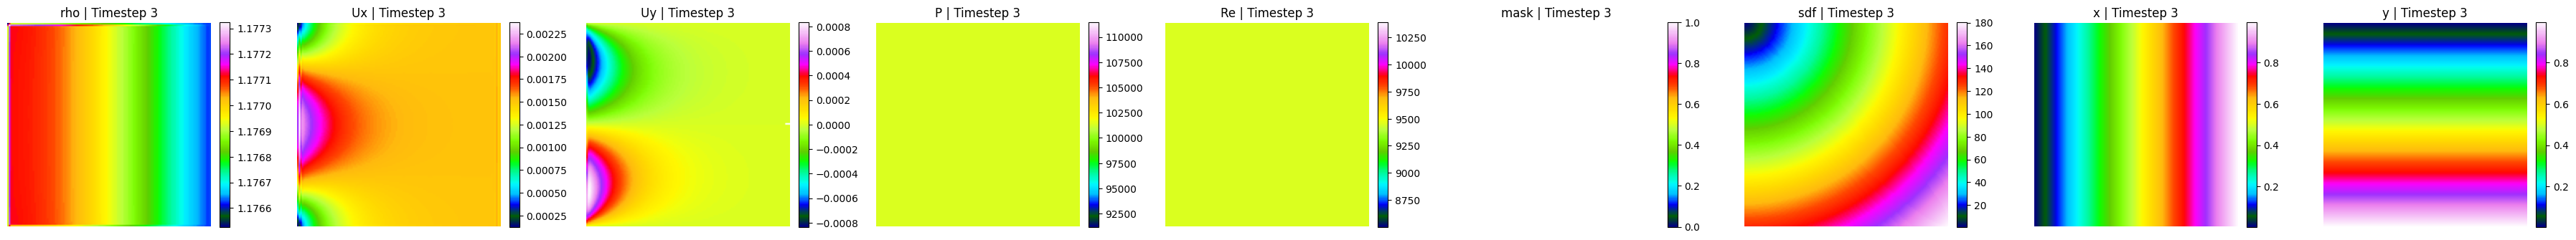

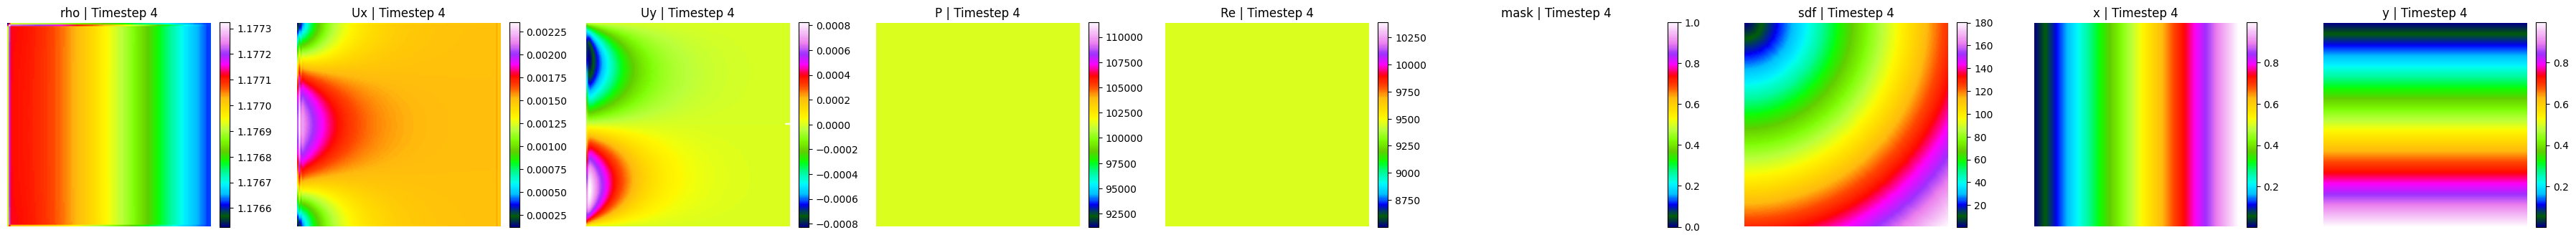

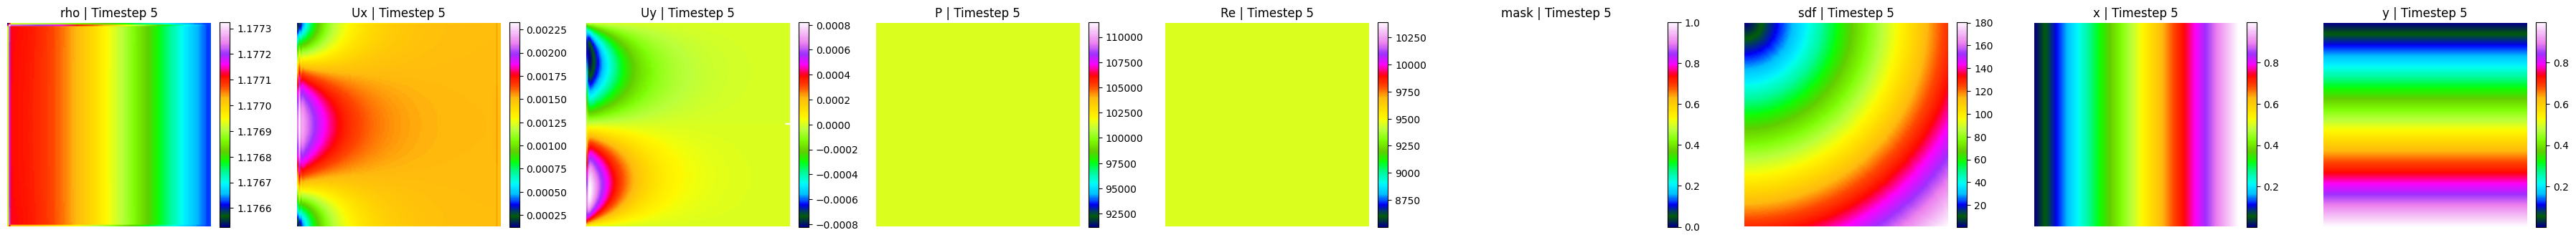

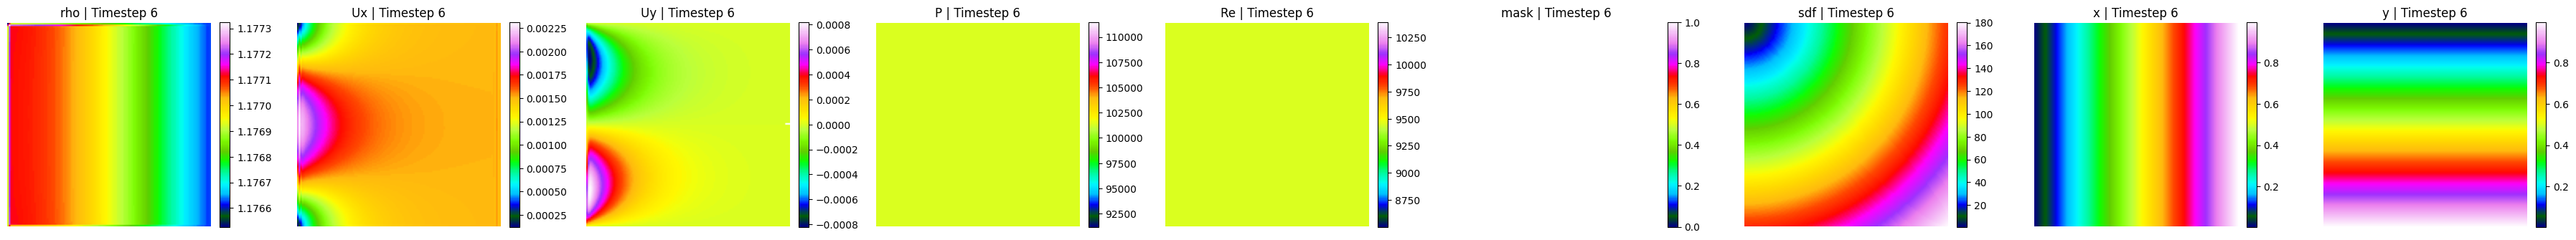

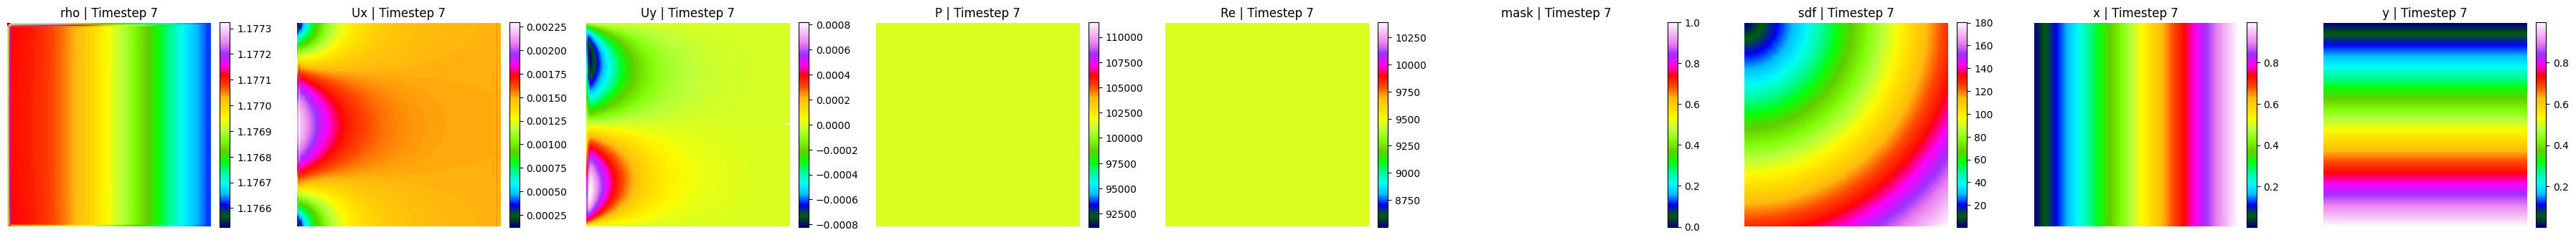

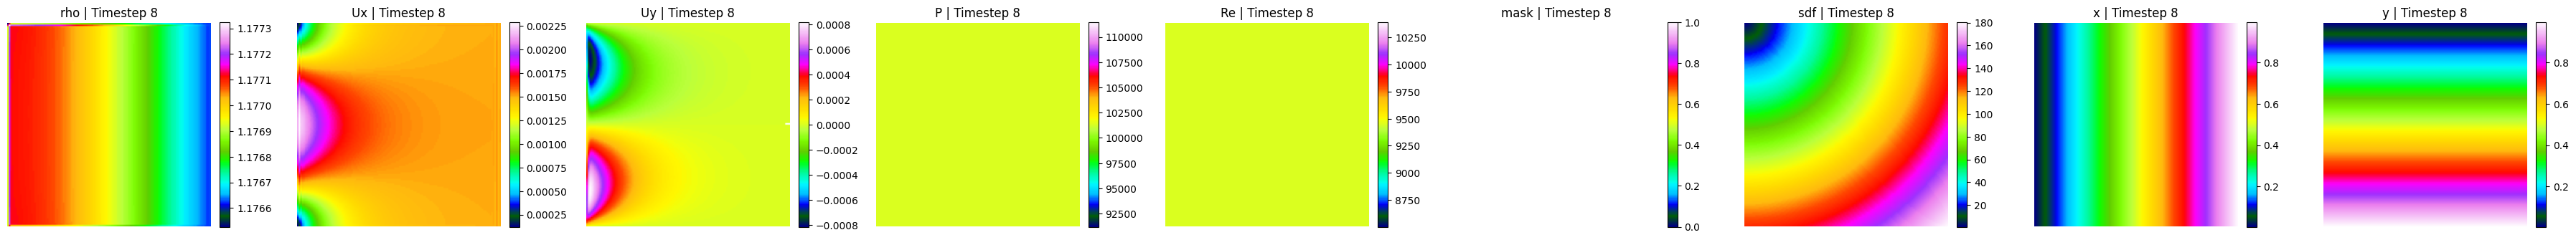

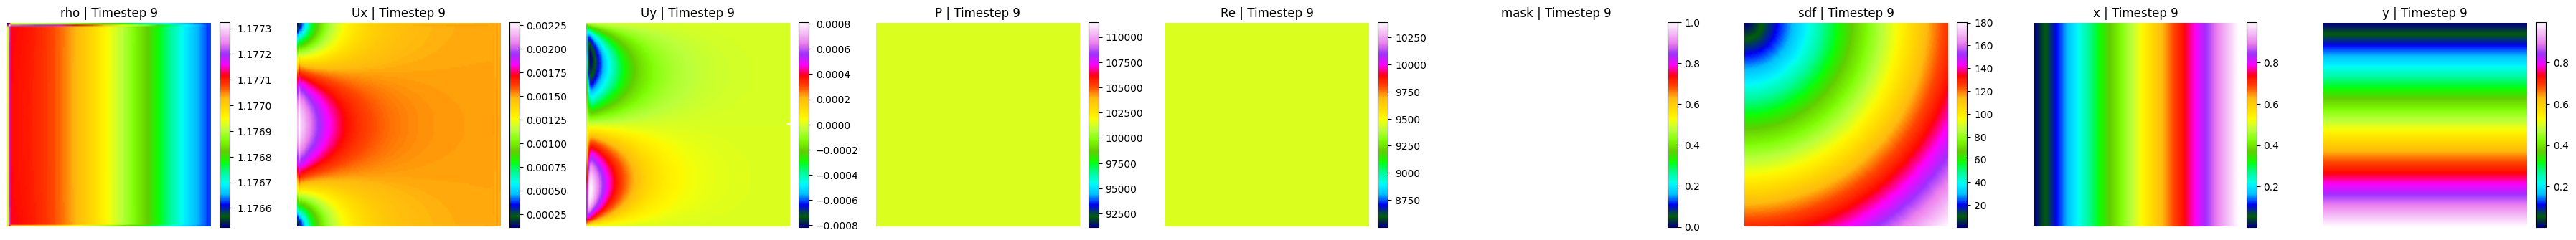

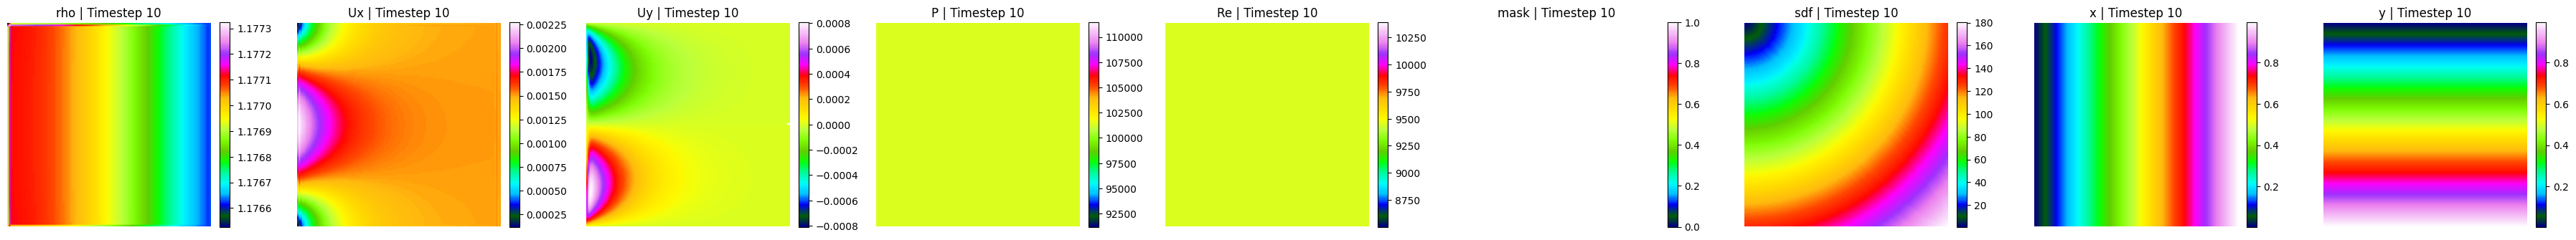

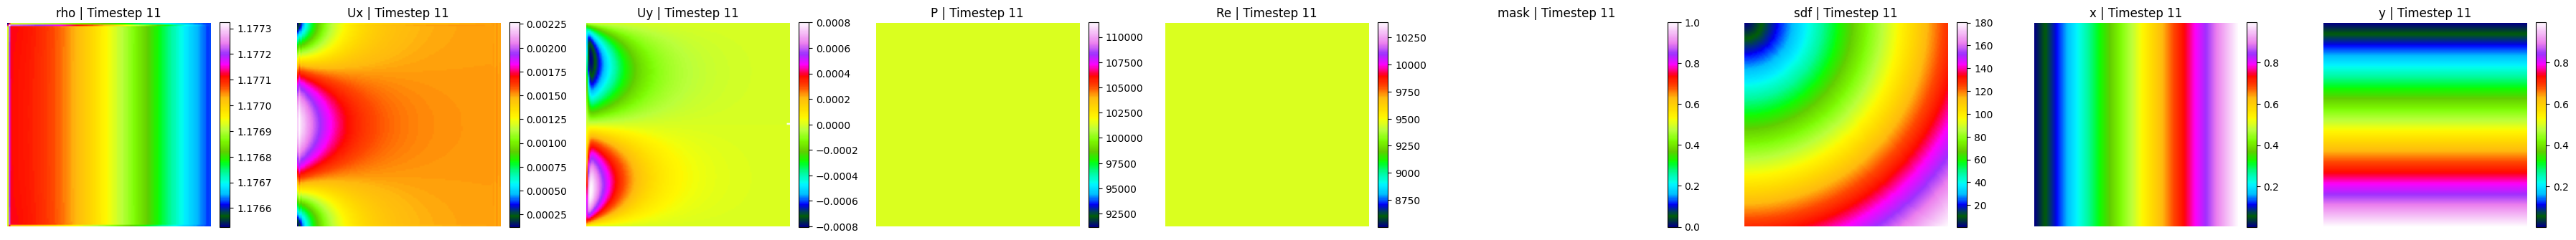

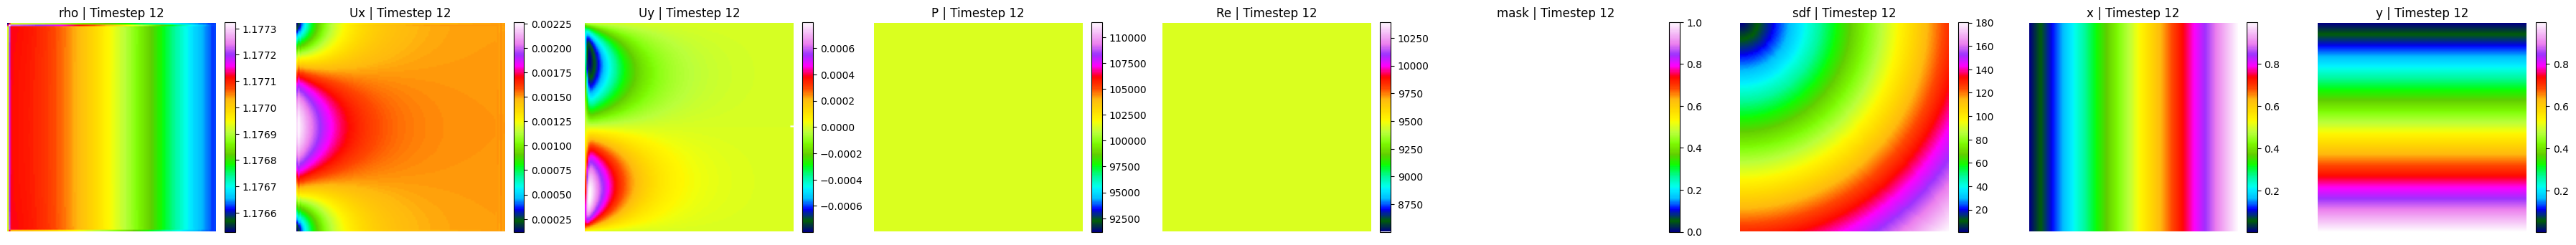

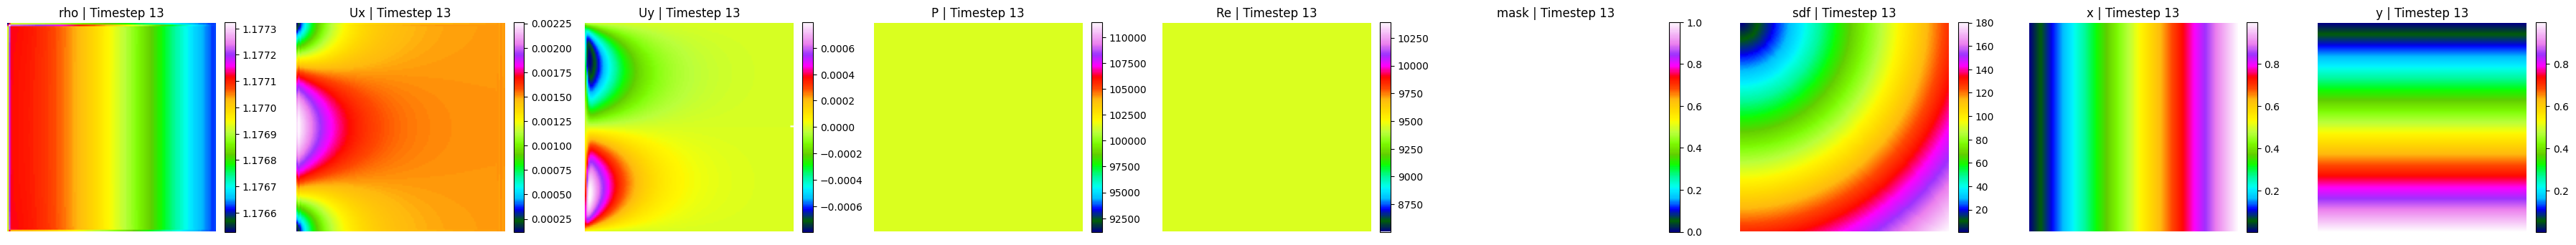

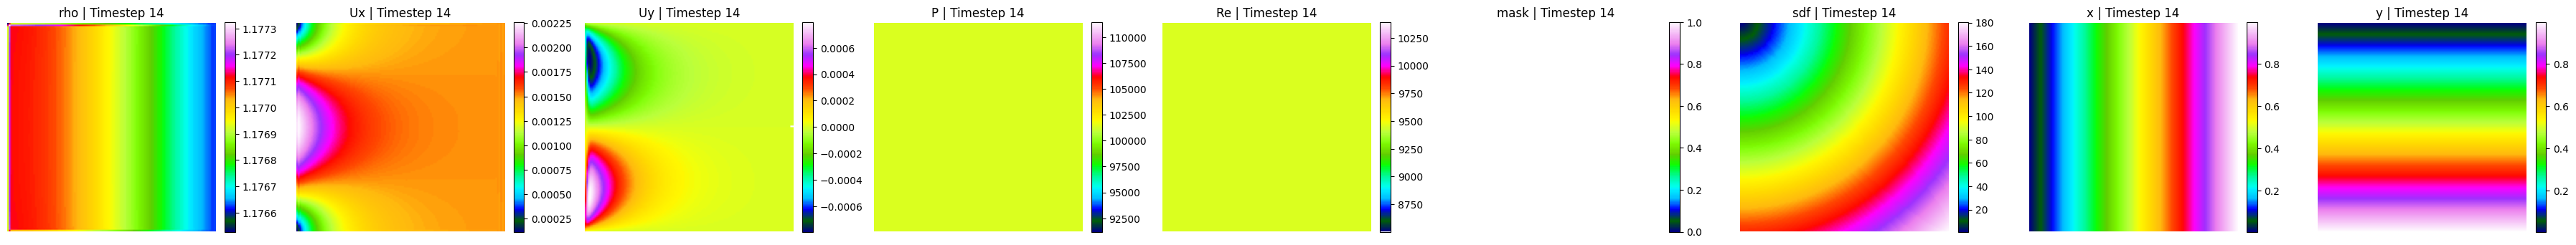

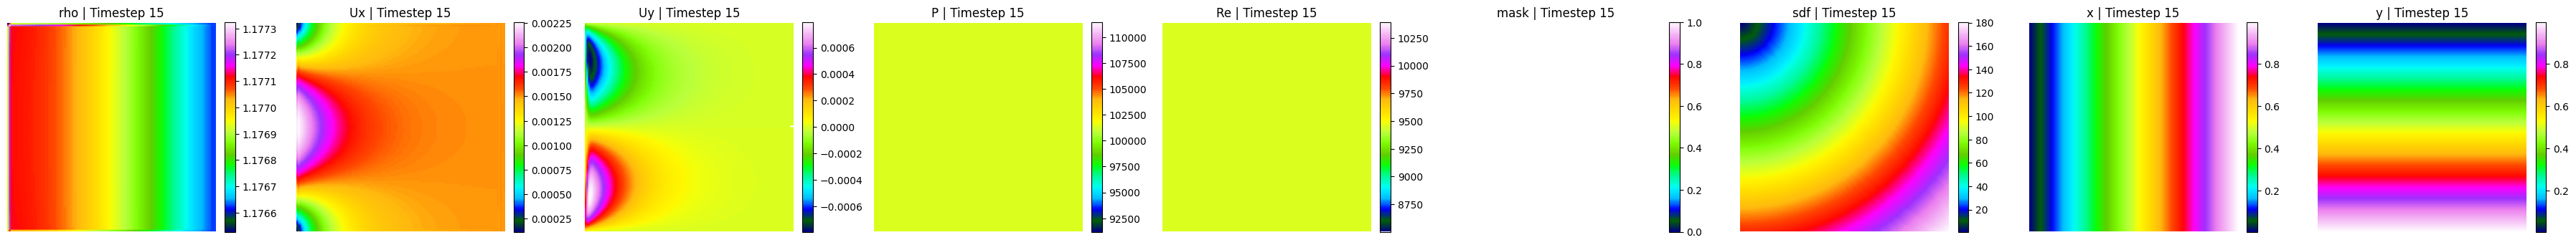

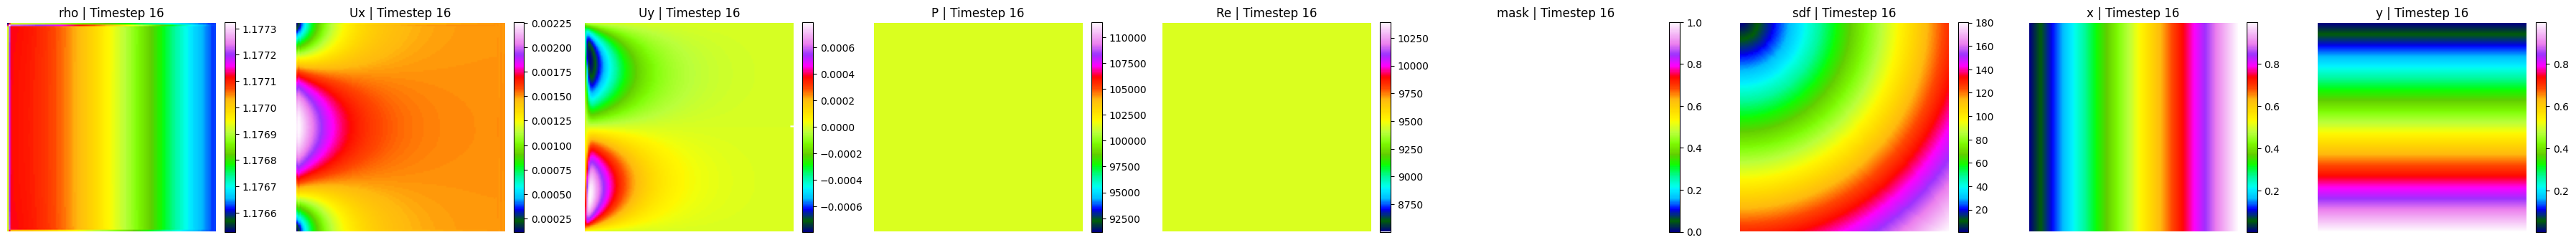

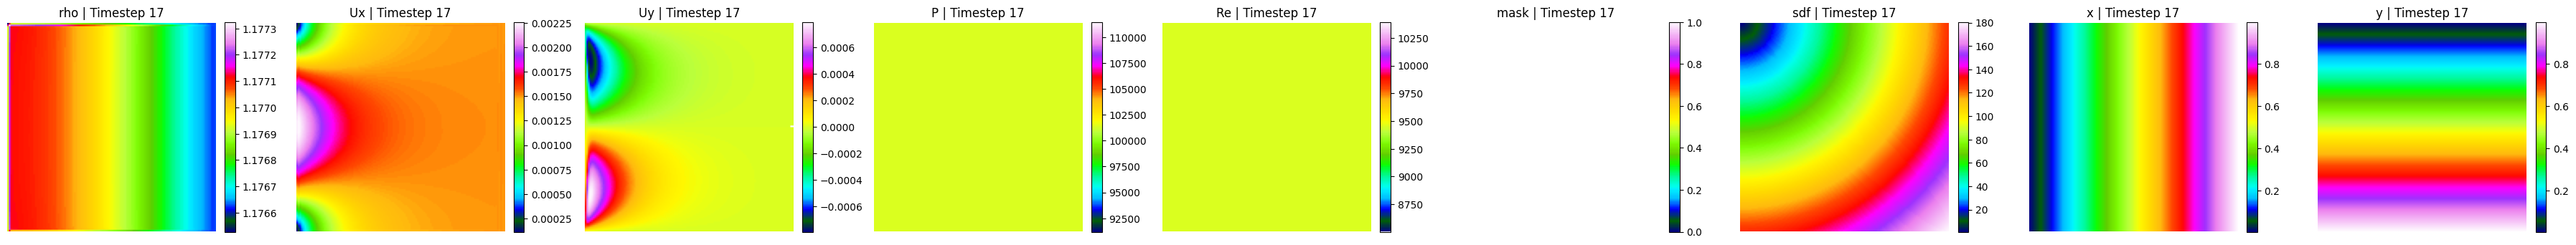

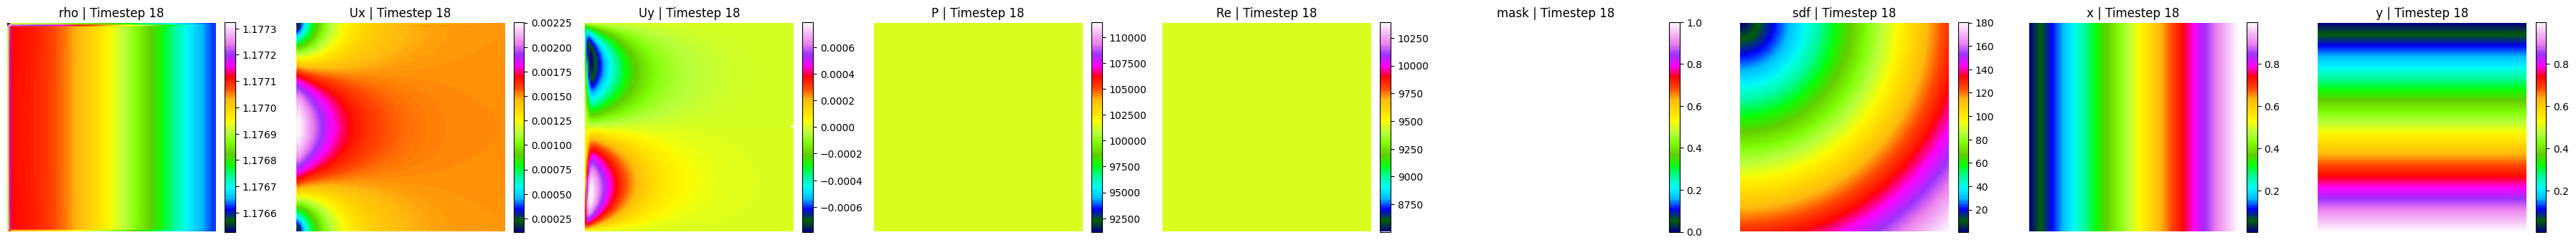

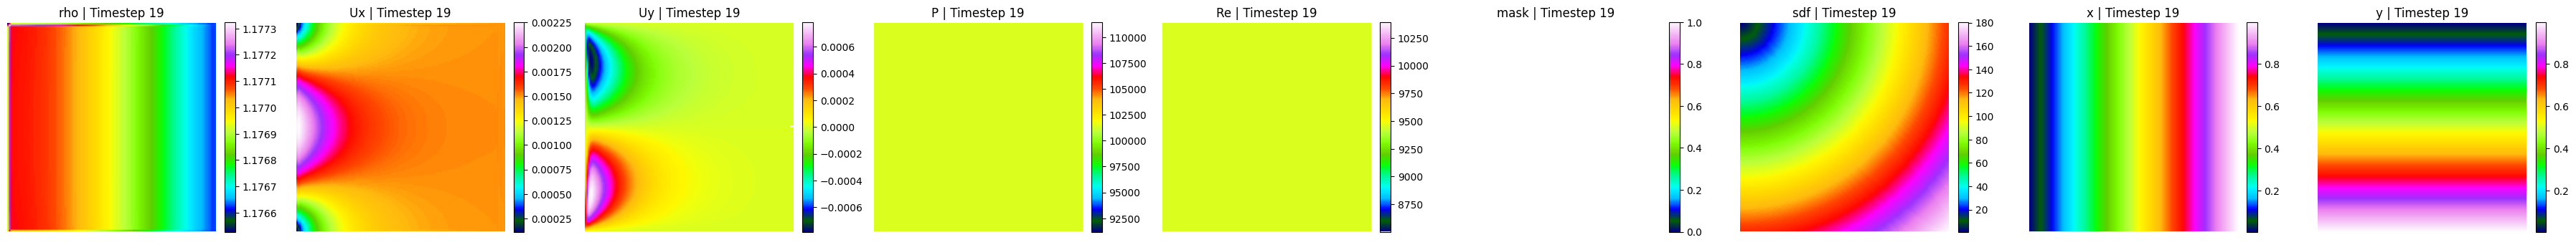

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from scipy.ndimage import distance_transform_edt
import matplotlib
import pandas as pd

# ---------------------------
# Functions for the Pipeline
# ---------------------------

def parse_c_file(file_path):
    """
    Parse the OpenFOAM cell centers file (named "C") to extract (x,y) coordinates.
    Expects the file to contain an 'internalField' entry.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    start_idx = None
    num_centres = None
    for i, line in enumerate(lines):
        if "internalField" in line:
            num_centres = int(lines[i+1].strip())
            start_idx = i + 3
            break

    if start_idx is None or num_centres is None:
        raise ValueError("Could not find 'internalField' or the number of cell centres in the file")

    coordinates = []
    for line in lines[start_idx:start_idx+num_centres]:
        if "(" in line and ")" in line:
            x, y, _ = map(float, line.strip("()\n").split())
            coordinates.append([x, y])
    return np.array(coordinates)


def reshape_trajectory_data(sim_data, cell_centers, grid_shape):
    """
    Reshape simulation data (timesteps, num_cells, 5) to a fixed grid of shape
         (timesteps, n_rows, n_cols, 9). The input sim_data channels are assumed to be:
           0: ρ
           1: Uₓ
           2: U_y
           3: P
           4: Reynolds number
           
    The output grid channels are:
           0: ρ
           1: Uₓ
           2: U_y
           3: P
           4: Reynolds number
           5: Binary mask (0 if a simulation cell exists; 1 if hole)
           6: SDF (signed distance function: positive in fluid, negative in hole)
           7: x‑coordinate
           8: y‑coordinate

    Mapping:
      For each cell center (x,y), compute:
         col = round((x - x_min) / (x_max - x_min) * (n_cols - 1))
         row = round((y - y_min) / (y_max - y_min) * (n_rows - 1))
      
    Cells that are not assigned any simulation cell remain with mask = 1.
    The SDF is computed using a distance transform on the mask.
    """
    n_rows, n_cols = grid_shape
    T = sim_data.shape[0]

    # Determine domain boundaries from cell_centers.
    x_min, x_max = np.min(cell_centers[:, 0]), np.max(cell_centers[:, 0])
    y_min, y_max = np.min(cell_centers[:, 1]), np.max(cell_centers[:, 1])

    # Allocate output grid with 9 channels.
    reshaped = np.zeros((T, n_rows, n_cols, 9), dtype=np.float32)

    # 1) Fill the x and y coordinate channels (channels 7 and 8).
    x_grid = np.linspace(x_min, x_max, n_cols)
    y_grid = np.linspace(y_min, y_max, n_rows)
    for row in range(n_rows):
        for col in range(n_cols):
            reshaped[:, row, col, 7] = x_grid[col]
            reshaped[:, row, col, 8] = y_grid[row]

    # 2) Build the binary mask.
    # Default is 1 (hole) everywhere.
    mask = np.ones((n_rows, n_cols), dtype=np.float32)
    mapping = []
    for (x, y) in cell_centers:
        col = int(round((x - x_min) / (x_max - x_min) * (n_cols - 1)))
        row = int(round((y - y_min) / (y_max - y_min) * (n_rows - 1)))
        mapping.append((row, col))
        mask[row, col] = 0  # Mark cell exists (fluid)

    # 3) Compute the SDF.
    # Our mask: 0 indicates fluid, 1 indicates hole.
    # Convert to fluid_mask: 1 for fluid, 0 for hole.
    fluid_mask = 1 - mask
    dist_fluid = distance_transform_edt(fluid_mask)
    dist_hole  = distance_transform_edt(1 - fluid_mask)
    sdf = dist_fluid - dist_hole  # positive in fluid, negative in hole

    # 4) Fill the simulation data into the grid using the computed mapping.
    # sim_data is assumed to have shape (T, num_cells, 5) with channels:
    # [ρ, Uₓ, U_y, P, Reynolds number]
    n_cells_sim = sim_data.shape[1]
    n_cells_mapping = len(mapping)
    if n_cells_mapping != n_cells_sim:
        # If there is a mismatch, use the minimum available.
        n_cells = min(n_cells_mapping, n_cells_sim)
        mapping = mapping[:n_cells]
    else:
        n_cells = n_cells_sim

    for t in range(T):
        for i, (row, col) in enumerate(mapping):
            if i >= n_cells:
                break
            # Fill channels 0 to 4 from simulation data.
            reshaped[t, row, col, 0:5] = sim_data[t, i, :]
        # For every timestep, fill the binary mask (channel 5) and the SDF (channel 6).
        reshaped[t, :, :, 5] = mask
        reshaped[t, :, :, 6] = sdf

    return reshaped


def combine_and_reshape_trajectories(dataset, cell_centers, grid_shape):
    """
    Combine all trajectory data from a results.npy file with shape
         (num_trajectories, timesteps, num_cells, 5)
    and reshape each trajectory onto a fixed grid of shape
         (num_trajectories, timesteps, n_rows, n_cols, 9)
    using the provided cell centers and grid shape.
    """
    num_trajectories = dataset.shape[0]
    combined_list = []
    
    for i in tqdm(range(num_trajectories), desc="Reshaping Trajectories"):
        # Extract simulation data for trajectory i.
        sim_data = dataset[i, :, :, :]  # shape: (timesteps, num_cells, 5)
        reshaped_data = reshape_trajectory_data(sim_data, cell_centers, grid_shape)
        combined_list.append(reshaped_data)
        gc.collect()
        
    combined = np.array(combined_list, dtype=np.float32)
    return combined


def plot_reshaped_trajectory(trajectory, channel_names=["ρ", "Ux", "Uy", "P", "mask"]):
    """
    Plot all timesteps of a reshaped trajectory.
    
    Args:
        trajectory (np.ndarray): Array of shape (timesteps, 128, 128, 5).
        channel_names (list): Names for the 5 channels.
    """
    timesteps = trajectory.shape[0]
    n_channels = trajectory.shape[-1]

    for t in range(timesteps):
        data = trajectory[t]  # shape: (128, 128, 5)

        fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))
        for ch in range(n_channels):
            im = axes[ch].imshow(data[:, :, ch], cmap="viridis")
            axes[ch].set_title(f"{channel_names[ch]} | Timestep {t}")
            axes[ch].axis("off")
            fig.colorbar(im, ax=axes[ch], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

def save_grid_to_file(grid, filename):
    """
    Saves the grid values to a text file in a readable format.
    Each row corresponds to a row in the grid, making it easy to verify values.
    """
    df = pd.DataFrame(grid)
    df.to_csv(filename, sep='\t', header=False, index=False)
    print(f"Saved grid values to {filename}")

# For testing the SDF and mask extraction:
def test_sdf_and_mask_extraction():
    # Load data from the testing file (assumes output has shape (..., 128, 128, 9))
    data = np.load("testingsdf.npy")
    
    # According to our new ordering:
    # SDF is in channel 6 and geometry mask is in channel 5.
    sdf_sample = data[0, 0, :, :, 6]         # first trajectory, first timestep, SDF values
    geometry_mask_sample = data[0, 0, :, :, 5] # first trajectory, first timestep, mask values
    
    # Save extracted grids to files.
    save_grid_to_file(sdf_sample, "sdf_values_from_testingsdf.txt")
    save_grid_to_file(geometry_mask_sample, "geometry_mask_from_testingsdf.txt")

def plot_with_hole_white(
    trajectory, 
    channel_names=["rho", "Ux", "Uy", "P", "Re", "mask", "sdf", "x", "y"], 
    tol=1e-8
):
    """
    Plot each timestep of a trajectory such that values whose absolute value
    is below a given tolerance are displayed as white (masked).
    """
    cmap = matplotlib.cm.get_cmap('gist_ncar').copy()
    cmap.set_bad(color='white')

    n_timesteps = trajectory.shape[0]
    for t in range(n_timesteps):
        data = trajectory[t]
        n_channels = data.shape[-1]
        
        fig, axes = plt.subplots(1, n_channels, figsize=(4*n_channels, 4))
        for ch in range(n_channels):
            masked_channel = np.ma.masked_where(np.abs(data[:, :, ch]) < tol, data[:, :, ch])
            valid_vals = data[:, :, ch][np.abs(data[:, :, ch]) >= tol]
            if valid_vals.size > 0:
                vmin, vmax = valid_vals.min(), valid_vals.max()
            else:
                vmin, vmax = 0, 1
            im = axes[ch].imshow(masked_channel, cmap=cmap, vmin=vmin, vmax=vmax)
            axes[ch].set_title(f"{channel_names[ch]} | Timestep {t}")
            axes[ch].axis("off")
            fig.colorbar(im, ax=axes[ch], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

# ---------------------------
# Main Pipeline
# ---------------------------
def main():
    # Define file paths (update these paths as needed)
    data_path = "/home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_External/Regular/results_batch_1.npy"  # Shape: (600,20,16320,4)
    c_file_path = "/home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_External/Regular/Design_Point_0/0/C"  # OpenFOAM C file
    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)
    
    # Load simulation data
    print(f"Loading simulation data from {data_path}")
    data = np.load(data_path)  # Expected shape: (600,20,16320,4)
    print(f"Data shape: {data.shape}")
    
    # Parse cell centers from the C file
    print(f"Parsing cell centers from C file: {c_file_path}")
    cell_centers = parse_c_file(c_file_path)
    print(f"Cell centers shape: {cell_centers.shape}")
    
    # Define target grid shape (128 x 128)
    grid_shape = (128, 128)
    
    # Combine and reshape all trajectories
    combined_data = combine_and_reshape_trajectories(data, cell_centers, grid_shape)
    print(f"Combined reshaped data shape: {combined_data.shape}")  # Expected: (600,20,128,128,5)
    
    # Save the combined reshaped data for later use
    combined_save_path = os.path.join(output_folder, "combined_reshaped.npy")
    np.save(combined_save_path, combined_data)
    print(f"Combined reshaped data saved to {combined_save_path}")
    
    # Plot a sample trajectory for visual inspection (e.g., first trajectory, timestep 0)
    sample_trajectory = combined_data[0]  # shape: (20,128,128,5)
    save_grid_to_file(combined_data[0, 0, :, :, 6], os.path.join(output_folder, "sdf.txt"))
    save_grid_to_file(combined_data[0, 0, :, :, 5], os.path.join(output_folder, "mask.txt"))

    # 6. Plot a sample trajectory
    print("Plotting sample trajectory (index 58)...")
    plot_with_hole_white(combined_data[0])
    
if __name__ == "__main__":
    main()
